In [16]:
from IPython import display

import time
import copy
import glob
import os
import copy

import tqdm
import numpy as np
from matplotlib import pyplot as plt

import torch
import torchvision
from torch import nn, optim
from torch.utils.data import Dataset
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
from torchvision.io import ImageReadMode, read_image

from xai.model import nets
import pylab as pl

from mmn_xai.data import dataset as xai_data

In [35]:
import random 

covid_train = glob.glob("./in/huse_red/train/covid/*.png")
no_covid_train = glob.glob("./in/huse_red/train/nocovid/*.png")

no_covid_train = random.choices(no_covid_train, k=len(covid_train))

covid_val = glob.glob("./in/huse_red/val/covid/*.png")
no_covid_val = glob.glob("./in/huse_red/val/nocovid/*.png")

no_covid_val = random.choices(no_covid_val, k=len(covid_val))

In [36]:
dataset_train = xai_data.ImageDataset(covid_train + no_covid_train, 
                                      (lambda x: read_image(x, ImageReadMode.GRAY)))
dataset_val = xai_data.ImageDataset(covid_val + no_covid_val, 
                                      (lambda x: read_image(x, ImageReadMode.GRAY)))

In [37]:
data_loader_train = DataLoader(dataset_train, batch_size=8, shuffle=True)
data_loader_val = DataLoader(dataset_val, batch_size=8, shuffle=True)

# Train

### Fine tunning

In [6]:
# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
MODEL_NAME = "resnet"
NUM_CLASSES = 2

BATCH_SIZE = 16
EPOCHS = 100
LEARNING_RATE = 0.000005
MOMENTUM = 0.985
# Flag for feature extracting. When False, we finetune the whole model, when True 
# we only update the reshaped layer params
REGRESSION = False
FEATURE_EXTRACT = False

DEVICE = "cuda:1" if torch.cuda.is_available() else "cpu"

In [7]:
net, input_size = nets.initialize_model(MODEL_NAME, NUM_CLASSES, FEATURE_EXTRACT, use_pretrained=True, device=DEVICE)
# net.features[0] = nn.Conv2d(1, 96, kernel_size=7, stride=2, padding=3,bias=False)
net.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3,bias=False)
net = net.to(DEVICE)

/home/collab/env_jupyter/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/collab/env_jupyter/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [8]:
params_to_update = net.parameters()
apartir = False

if FEATURE_EXTRACT:
    params_to_update = []
    for name,param in net.named_parameters():
        if "layer4" in name:
            apartir = True
            
        if apartir:
            print(name)
            params_to_update.append(param)

# Observe that all parameters are being optimized
optimizer = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

In [9]:
def _show_progress(history, phases):
    plt.figure(figsize=(15,10))

    for phase in phases:
        pl.subplot(1, 2, 1)
        pl.title(f'Best Acc: {max(history[phase]["acc"])}')

        pl.plot(history[phase]['acc'], label=phase.capitalize())
        pl.legend()

    for phase in phases:
        pl.subplot(1, 2, 2)
        pl.title(f'Best loss: {min(history[phase]["loss"])}')
        pl.plot(history[phase]['loss'], label=phase.capitalize())

        pl.legend()
    display.clear_output(wait=True) 
    display.display(pl.gcf())
    plt.close() 
    
def train_model(
    model, 
    dataloaders, 
    criterion, 
    optimizer, 
    num_epochs=25, 
    is_inception=False, 
    do_validation=True, 
    regression=False,
    plot_acc=False,
    device="cpu"
):
    since = time.time()

    history = {}
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_acc_std = 0.0
    best_loss = 0.0
    best_loss_std = 0.0
    
    phases = ['train']
    
    if do_validation:
        phases.append('val')
        
    epoch_loss = 0
    epoch_acc = 0
    try:
        for epoch in range(num_epochs):
            # Each epoch has a training and validation phase
            for phase in phases:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = []
                running_acc = []

                pbar = tqdm.tqdm(dataloaders[phase], desc='Time, he\'s waiting in the wings')
                # Iterate over data.
                for inputs, labels in pbar:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    inputs = inputs.type(torch.float32)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        # Get model outputs and calculate loss
                        # Special case for inception because in training it has an auxiliary output. In train
                        #   mode we calculate the loss by summing the final output and the auxiliary output
                        #   but in testing we only consider the final output.
                        outputs = model(inputs)

                        loss = criterion(outputs.reshape(1, -1), labels.reshape(1, -1))

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss.append((loss.item() * inputs.size(0)) / len(outputs))
                    if not regression:
                        preds = torch.argmax(outputs, 1)
                        labels = torch.argmax(labels, 1)

                        aux = (preds == labels)
                        acc = (torch.sum(aux).double().cpu().detach().numpy() / len(outputs))
                        running_acc.append(acc)
                    else:
                        acc = 1 - torch.sum(torch.abs(outputs - labels)).double().cpu().detach().numpy() / len(outputs)
                        running_acc.append(acc)

                    pbar.set_description('Epoch {}/{} - {} - ACC: {:.4f} LOSS: {:.4f}'.format(epoch, num_epochs - 1, phase.capitalize(), np.mean(running_acc), np.mean(running_loss)))

                epoch_loss = np.mean(running_loss)
                epoch_acc = np.mean(running_acc)

                # deep copy the model
                if (phase == 'val' or not 'val' in phases) and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_loss = epoch_loss

                    best_loss_std = np.std(running_loss)
                    best_acc_std = np.std(running_acc)

                    best_model_wts = copy.deepcopy(model.state_dict())

                if phase not in history:
                    history[phase] = {"acc": [], "loss": []}

                history[phase]["acc"].append(epoch_acc)
                history[phase]["loss"].append(epoch_loss)
            if plot_acc:
                _show_progress(history, phases)
    except KeyboardInterrupt:
        print('Interrupted')
    except Exception as e:
        print(e)
        traceback.print_exc()
    finally:
        time_elapsed = time.time() - since
        print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
        print('Best val Acc: [{:4f}-{:4f}]'.format(best_acc - best_acc_std/2, best_acc + best_acc_std/2))
        
        # load best model weights
        model.load_state_dict(best_model_wts)
        return model, history

In [34]:
n = 0
acum = 0
for img, gt in tqdm.tqdm(data_loader_val):
    res = abs(torch.argmax(net(img.float().cuda(DEVICE)), axis=1)).cpu()
    reduced_gt = torch.argmax(gt, axis=1)
    
    acum += torch.sum(res == reduced_gt)
    n += 1
    
acum / (n * 8)

100%|██████████| 15/15 [00:01<00:00, 14.18it/s]


tensor(0.7250)

In [26]:
torch.cuda.empty_cache()

In [11]:
# net = nn.DataParallel(net)

In [23]:
net

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

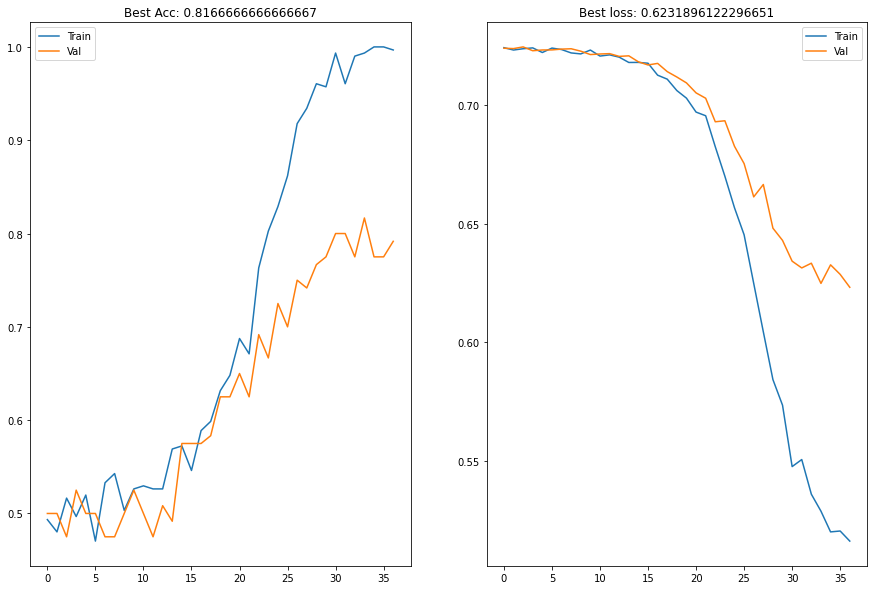

Epoch 37/99 - Val - ACC: 0.7917 LOSS: 0.6190: 100%|██████████| 15/15 [00:00<00:00, 16.36it/s]


In [ ]:
if REGRESSION:
    criterion = nn.L1Loss()
else:
    criterion = nn.BCEWithLogitsLoss()
optimizer = optimizer_ft = torch.optim.Adam(net.parameters(), lr=LEARNING_RATE, weight_decay=0.005)

# Train and evaluate
net, hist = train_model(
    net, 
    {"train": data_loader_train, "val": data_loader_val}, 
    criterion, 
    optimizer, 
    num_epochs=EPOCHS, 
    do_validation=True,
    regression=REGRESSION,
    plot_acc=True,
    device = DEVICE
)

# torch.save(net.state_dict(), name)

In [ ]:
torch.save(net.state_dict(), "./out/huse_2.pt")

## SIDU

In [13]:
model_ft = model_ft.eval()

In [ ]:
# type(model_ft.layer4[1].conv2.weight)
activation = {}

def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()

    return hook

model_ft.module.layer4[1].conv2.register_forward_hook(get_activation('layer4_1_conv2'))

In [ ]:
plt.figure(figsize=(25, 25))

for i in tqdm.tqdm(range(25)):
    ax1 = plt.subplot(5, 5, i + 1)

    img_iter = img[i:i+1,:,:,:]
    model_ft(img_iter)
    activacio_conv = activation['layer4_1_conv2']
    
    explanation = sidu.sidu(model_ft, activacio_conv, img_iter)
    explanation = explanation.cpu().detach().numpy()
    
    plt.imshow(img_iter[0, 0,:,:].cpu().numpy(), cmap='gray');
    plt.imshow(explanation, alpha=.5);
    ax1.title.set_text(f"GT {np.argmax(labels[i])} Predicció {np.argmax(preds[i])}");
    torch.cuda.empty_cache()
    # sidu.sidu(model_ft, model_ft.layer4[1].conv2, img[0,:,:,:])

In [ ]:
plt.figure(figsize=(25, 25))
torch.cuda.empty_cache()

for i in tqdm.tqdm(range(25)):
    ax1 = plt.subplot(5, 5, i + 1)

    img_iter = img[i:i+1,:,:,:]
    model_ft(img_iter)
    activacio_conv = activation['layer4_1_conv2']
    
    numpy_img = img[i, 0, :, :].cpu().numpy()
    
    explanation = sidu.sidu(model_ft, activacio_conv, img_iter)
    explanation = explanation.cpu().detach().numpy()
    
    percentiles_value = np.percentile(explanation, 90)
    
    plt.imshow((explanation > percentiles_value) * numpy_img, cmap='gray');
    
    ax1.title.set_text(f"GT {np.argmax(labels[i])} Predicció {np.argmax(preds[i])}");
    torch.cuda.empty_cache()

# GradCAM

In [ ]:
interpreter = GradCAMInterpreter(model_ft.module, ["0", "1"], None, (512, 512), "layer4")
imgs = []
interpretations = []

In [ ]:
plt.figure(figsize=(25, 25))

for i in range(25):
    ax1 = plt.subplot(5, 5, i + 1)
    cam = interpreter.interpret(img[i: i+ 1,:,:,:])
    
    imgs.append(img[i:i+1, :, :, :])
    interpretations.append(cam[0, 0, : ,: ].cpu().numpy())
    
    plt.imshow(img[i, 0, :, :].cpu().numpy(), cmap='gray');
    plt.imshow(cam[0, 0, : ,: ].cpu().numpy(), alpha=.5);
    ax1.title.set_text(f"GT {np.argmax(labels[i])} Predicció {np.argmax(preds[i])}")

In [ ]:
plt.figure(figsize=(25, 25))

for i, (numpy_cam, numpy_img) in enumerate(zip(interpretations, imgs)):
    ax1 = plt.subplot(5, 5, i + 1)
    numpy_img = numpy_img[0, 0, :, :].cpu().numpy()
    
    percentiles_value = np.percentile(numpy_cam, 90)
    
    plt.imshow((numpy_cam > percentiles_value) * numpy_img, cmap='gray');
    ax1.title.set_text(f"GT {np.argmax(labels[i])} Predicció {np.argmax(preds[i])}")

## Metrics

In [ ]:
torch.cuda.empty_cache()
model_ft = model_ft.eval()

aopc_values = uib_metrics.aopc.aopc(imgs, interpretations, lambda x: torch.squeeze(model_ft(x)), (50, 50), 0, True)
aopc_values

In [ ]:
sparcity_value = [uib_metrics.sparcity.sparcity(interpret) for interpret in interpretations]
sparcity_value = np.mean(sparcity_value)
sparcity_value

In [ ]:
regions, regions_values = x_utils.get_regions(interpretations[1], (10, 10))

In [ ]:
aux = deletion(imgs[2], torch.tensor(interpretations[2]), lambda x: torch.squeeze(model_ft(x)).cpu().detach().numpy(), (20, 20), 0)

In [ ]:
from matplotlib import pyplot as plt

_, _ perts, sal = aux

aux2 = np.array(perts)
aux1 = np.array(sal)

plt.plot(aux2 / aux2.max())
plt.plot(aux1 / aux1.max())

In [ ]:
model_ft(imgs[0])

In [ ]:
uib_metrics.calibration_rate.deletion(imgs[0], torch.tensor(interpretations[0]), lambda x: torch.squeeze(model_ft(x)).cpu().detach().numpy(), (5, 5), 0)

In [ ]:
uib_metrics.calibration_rate.deletion(imgs[0], torch.tensor(interpretations[0]), lambda x: torch.squeeze(model_ft(x)).cpu().detach().numpy(), (10, 10), 0)

In [ ]:
f_one = 0
for img, interpret in zip(imgs[:5], interpretations[:5]):
    f_one += faithfullness(img, torch.tensor(interpret), lambda x: torch.squeeze(model_ft(x)).cpu().detach().numpy(), (1, 1), 0)
    print(f_one)
f_one /= 5

# GradCAM ++

In [ ]:
target_layers = [model_ft.module.layer4[-1]]
interpreter = GradCAMPlusPlus(model=model_ft, target_layers=target_layers, use_cuda=True)

In [ ]:
imgs[0].shape

In [ ]:
plt.figure(figsize=(25, 25))

for i in range(25):
    ax1 = plt.subplot(5, 5, i + 1)
    cam_plus_plus = interpreter(input_tensor = img[i: i+ 1,:,:,:])
    grayscale_cam = cam_plus_plus[0, :]
        
    plt.imshow(img[i, 0, :, :].cpu().numpy(), cmap='gray');
    plt.imshow(grayscale_cam[: ,: ], alpha=.5);
    ax1.title.set_text(f"GT {np.argmax(labels[i])} Predicció {np.argmax(preds[i])}")

In [ ]:
plt.figure(figsize=(25, 25))

for i in range(25):
    ax1 = plt.subplot(5, 5, i + 1)
    cam_plus_plus = interpreter(input_tensor = img[i: i+ 1,:,:,:])
    grayscale_cam = cam_plus_plus[0, :]
    
    numpy_img = img[i, 0, :, :].cpu().numpy()
    
    percentiles_value = np.percentile(grayscale_cam, 90)
    
    plt.imshow((grayscale_cam > percentiles_value) * numpy_img, cmap='gray');
    ax1.title.set_text(f"GT {np.argmax(labels[i])} Predicció {np.argmax(preds[i])}")

# Score cam

In [ ]:
target_layers = [model_ft.module.layer4[-1]]
interpreter = ScoreCAM(model=model_ft, target_layers=target_layers, use_cuda=True)

imgs = []
interpretations = []

In [ ]:
labels[0]

In [ ]:
plt.figure(figsize=(25, 25))

for i in range(25):
    ax1 = plt.subplot(5, 5, i + 1)
    cam_plus_plus = interpreter(input_tensor = img[i: i+ 1,:,:,:])
    grayscale_cam = cam_plus_plus[0, :]
    
    imgs.append(img[i: i+ 1,:,:,:])
    interpretations.append(grayscale_cam)
        
    plt.imshow(img[i, 0, :, :].cpu().numpy(), cmap='gray');
    plt.imshow(grayscale_cam[: ,: ], alpha=.5);
    ax1.title.set_text(f"GT {np.argmax(labels[i])} Predicció {np.argmax(preds[i])}")

In [ ]:
aux = torch.zeros_like(img[18: 18+ 1,:,:,:])
# aux[:] = 255

In [ ]:
model_ft(aux)

In [ ]:
len(interpretations)

In [ ]:
plt.figure(figsize=(25, 25))

for i, (numpy_cam, numpy_img) in enumerate(zip(interpretations, imgs)):
    ax1 = plt.subplot(5, 5, i + 1)
    numpy_img = numpy_img[0, 0, :, :].cpu().numpy()
    
    percentiles_value = np.percentile(numpy_cam, 90)
    
    plt.imshow((numpy_cam > percentiles_value) * numpy_img, cmap='gray');
#     ax1.title.set_text(f"GT {np.argmax(labels[i])} Predicció {np.argmax(preds[i])}")
    
# plt.figure(figsize=(25, 25))

# for i, (img, intepret) in enumerate(zip(imgs, interpretations)):
#     ax1 = plt.subplot(5, 5, i + 1)
    
#     numpy_img = img[0,0,:,:].cpu().numpy()
    
#     percentiles_value = np.percentile(intepret, 90)
    
#     plt.imshow((intepret > percentiles_value) * numpy_img, cmap='gray');
#     ax1.title.set_text(f"GT {int((labels[i]) > 0.5)} Predicció {int(preds[i] > 0.5)}")

In [ ]:
model_ft(torch.zeros_like(imgs[0]))

In [ ]:
from uib_xai.metrics import utils as x_utils
from scipy import stats
from numpy import linalg as LA

def deletion(image, saliency_map, prediction_func, region_shape, perturbation_value):
    """

    Args:
        image:
        saliency_map:
        prediction_func:
        region_shape:
        perturbation_value:

    Returns:

    """
    regions, regions_values = x_utils.get_regions(saliency_map.numpy(), region_shape)

    pre_prediction = prediction_func(image)
    original_id = np.argmax(pre_prediction)

    img_perturbed = torch.clone(image.detach())
    perturbation_scores = []
    scores = [pre_prediction[original_id]]

    for region in regions:
        img_perturbed = x_utils.perturb_img(img_perturbed, region, region_shape, perturbation_value)
        now_pred = prediction_func(img_perturbed)
        
        scores.append(now_pred[original_id])
        
        perturbation_scores.append(pre_prediction[original_id] - now_pred[original_id])
        pre_prediction = now_pred

    faith, _ = stats.pearsonr(perturbation_scores, regions_values)

    return faith, img_perturbed, perturbation_scores, regions_values, scores

In [ ]:
from matplotlib import pyplot as plt

### Valor a 1

In [ ]:
fig = plt.figure(figsize=(25, 25))

for i in range(25):
    torch.cuda.empty_cache()
    dc, perturbation_tot, perts, sal, scores  = deletion(imgs[i], torch.tensor(interpretations[i]), lambda x: torch.squeeze(model_ft(x)).cpu().detach().numpy(), (10, 10), 1)

    perts = np.array(perts)[:]
    sal = np.array(sal)[:]
    
    ax = plt.subplot(5, 10, i+1)
    plt.plot(perts / perts.max(), label="Score perturbation")
    plt.plot(sal / sal.max(), label="Saliency")
    ax.title.set_text(f"DC {dc}")
    plt.legend();
    
    plt.subplot(5, 10, i+25)
    plt.plot(scores)

## Valor a 0

In [ ]:
fig = plt.figure(figsize=(25, 25))

for i in range(9):
    torch.cuda.empty_cache()
    dc, perturbation_tot, perts, sal, scores  = deletion(imgs[i], torch.tensor(interpretations[i]), lambda x: torch.squeeze(model_ft(x)).cpu().detach().numpy(), (10, 10), 0)

    perts = np.array(perts)[:]
    sal = np.array(sal)[:]
    
    ax = plt.subplot(6, 3, i+1)
    plt.plot(perts / perts.max(), label="Score perturbation")
    plt.plot(sal / sal.max(), label="Saliency")
    ax.title.set_text(f"DC {dc}")
    plt.legend();
    
    plt.subplot(6, 3, i+10)
    plt.plot(scores)

In [ ]:
plt.plot(aux2 / aux2.max(), label="Score perturbation")
plt.plot(aux1 / aux1.max(), label="Saliency")
plt.legend();

In [ ]:
plt.plot(scores)

### Valor a mitjana

In [ ]:
plt.plot(aux2 / aux2.max(), label="Score perturbation")
plt.plot(aux1 / aux1.max(), label="Saliency")
plt.legend();

In [ ]:
plt.plot(scores)

### Valor a 0

In [ ]:
plt.plot(aux2 / aux2.max(), label="Score perturbation")
plt.plot(aux1 / aux1.max(), label="Saliency")
plt.legend();

In [ ]:
plt.plot(scores)

In [ ]:
model_ft = model_ft.eval()

In [ ]:
model_ft(imgs[0])

In [ ]:
model_ft(perturbation_tot)

In [ ]:
plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(imgs[0].cpu().numpy()[0, 0, :, :])

plt.subplot(1, 2, 2)
plt.imshow(perturbation_tot.cpu().numpy()[0, 0, :, :])

In [ ]:
aux[0]

# Smooth Grad

In [ ]:
interpretor = SmoothGrad(model_ft, [], None, 0.8, 100)

In [ ]:
plt.figure(figsize=(25, 25))

for i in range(25):
    ax1 = plt.subplot(5, 5, i + 1)   
    endpoint = interpretor.interpret(img[i: i+ 1,:,:,:])

    min_end = endpoint.min()
    max_end = endpoint.max()

    endpoint = (endpoint - min_end) / (max_end - min_end)
        
    plt.imshow(img[i, 0, :, :].cpu().numpy(), cmap='gray');
    plt.imshow(endpoint[0, 0, :, :] * 255, alpha=.5);
    ax1.title.set_text(f"GT {np.argmax(labels[i])} Predicció {np.argmax(preds[i])}")

In [ ]:
plt.figure(figsize=(25, 25))

for i in range(25):
    ax1 = plt.subplot(5, 5, i + 1)
    endpoint = interpretor.interpret(img[i: i+ 1,:,:,:])

    min_end = endpoint.min()
    max_end = endpoint.max()

    endpoint = (endpoint - min_end) / (max_end - min_end)
    endpoint = endpoint[0, 0, :, :]
    
    percentiles_value = np.percentile(endpoint, 90)
    numpy_img = img[i, 0, :, :].cpu().numpy()
    
    plt.imshow((endpoint > percentiles_value) * numpy_img, cmap='gray');
    ax1.title.set_text(f"GT {np.argmax(labels[i])} Predicció {np.argmax(preds[i])}")

# K. Simonyan et al.

In [ ]:
interpretor = VanillaBackprop(model_ft, [], None)

In [ ]:
plt.figure(figsize=(25, 25))

for i in range(25):
    ax1 = plt.subplot(5, 5, i + 1)   
    endpoint = interpretor.interpret(img[i: i+ 1,:,:,:])

    min_end = endpoint.min()
    max_end = endpoint.max()

    endpoint = (endpoint - min_end) / (max_end - min_end)
        
    plt.imshow(img[i, 0, :, :].cpu().numpy(), cmap='gray');
    plt.imshow(endpoint[0, 0, :, :] * 255, alpha=.5);
    ax1.title.set_text(f"GT {np.argmax(labels[i])} Predicció {np.argmax(preds[i])}")

In [ ]:
plt.figure(figsize=(25, 25))

for i in range(25):
    ax1 = plt.subplot(5, 5, i + 1)
    endpoint = interpretor.interpret(img[i: i+ 1,:,:,:])

    min_end = endpoint.min()
    max_end = endpoint.max()

    endpoint = (endpoint - min_end) / (max_end - min_end)
    endpoint = endpoint[0, 0, :, :]
    
    percentiles_value = np.percentile(endpoint, 90)
    numpy_img = img[i, 0, :, :].cpu().numpy()
    
    plt.imshow((endpoint > percentiles_value) * numpy_img, cmap='gray');
    ax1.title.set_text(f"GT {np.argmax(labels[i])} Predicció {np.argmax(preds[i])}")

# Guided Backpropagation

In [ ]:
interpretor = GuidedBackprop(model_ft, [], None)

In [ ]:
plt.figure(figsize=(25, 25))

for i in range(25):
    ax1 = plt.subplot(5, 5, i + 1)   
    endpoint = interpretor.interpret(img[i: i+ 1,:,:,:])

    min_end = endpoint.min()
    max_end = endpoint.max()

    endpoint = (endpoint - min_end) / (max_end - min_end)
        
    plt.imshow(img[i, 0, :, :].cpu().numpy(), cmap='gray');
    plt.imshow(endpoint[0, 0, :, :] * 255, alpha=.5);
    ax1.title.set_text(f"GT {np.argmax(labels[i])} Predicció {np.argmax(preds[i])}")

In [ ]:
plt.figure(figsize=(25, 25))

for i in range(25):
    ax1 = plt.subplot(5, 5, i + 1)
    endpoint = interpretor.interpret(img[i: i+ 1,:,:,:])

    min_end = endpoint.min()
    max_end = endpoint.max()

    endpoint = (endpoint - min_end) / (max_end - min_end)
    endpoint = endpoint[0, 0, :, :]
    
    percentiles_value = np.percentile(endpoint, 90)
    numpy_img = img[i, 0, :, :].cpu().numpy()
    
    plt.imshow((endpoint > percentiles_value) * numpy_img, cmap='gray');
    ax1.title.set_text(f"GT {np.argmax(labels[i])} Predicció {np.argmax(preds[i])}")

# Integrated Gradients

In [ ]:
baseline = torch.zeros(img[0:1,:,:,:].size())
interpretor = IntegratedGrad(model_ft, [], None, baseline, 100)

In [ ]:
plt.figure(figsize=(25, 25))

for i in range(16):
    ax1 = plt.subplot(4, 4, i + 1)   
    
    baseline = torch.zeros(img[i: i+ 1,:,:,:].size())

    interpretor = IntegratedGrad(model_ft, [], None, baseline, 100)
#     endpoint = interpretor.interpret(img)
    
    endpoint = interpretor.interpret(img[i: i+ 1,:,:,:])

    min_end = endpoint.min()
    max_end = endpoint.max()

    endpoint = (endpoint - min_end) / (max_end - min_end)
        
    plt.imshow(img[i, 0, :, :].cpu().numpy(), cmap='gray');
    plt.imshow(endpoint[0, 0, :, :] * 255, alpha=.5);
    ax1.title.set_text(f"GT {np.argmax(labels[i])} Predicció {np.argmax(preds[i])}")

In [ ]:
plt.figure(figsize=(25, 25))

for i in range(16):
    ax1 = plt.subplot(4, 4, i + 1)   
#     endpoint = interpretor.interpret(img[i: i+ 1,:,:,:])
    baseline = torch.zeros(img[i: i+ 1,:,:,:].size())

    interpretor = IntegratedGrad(model_ft, [], None, baseline, 100)
    endpoint = interpretor.interpret(img[i: i+ 1,:,:,:])

    min_end = endpoint.min()
    max_end = endpoint.max()

    endpoint = (endpoint - min_end) / (max_end - min_end)
    endpoint = endpoint[0, 0, :, :]
    
    percentiles_value = np.percentile(endpoint, 90)
    numpy_img = img[i, 0, :, :].cpu().numpy()
        
    plt.imshow((endpoint > percentiles_value) * numpy_img, cmap='gray');
    ax1.title.set_text(f"GT {np.argmax(labels[i])} Predicció {np.argmax(preds[i])}")  

In [ ]:
from lime import lime_image
import torch.nn.functional as F
from skimage.segmentation import mark_boundaries

In [ ]:
def batch_predict(images):
    img = np.transpose(images, (0, 3, 1, 2))
    img_t = torch.from_numpy(img)
    img_t = img_t.to(device)

    logits = model_ft(img_t)
    probs = F.softmax(logits, dim=1)
    return probs.detach().cpu().numpy()

In [ ]:
img[0,:,:,:].cpu().permute(1, 2, 0).numpy().shape

In [ ]:
explainer = lime_image.LimeImageExplainer()

In [ ]:
plt.figure(figsize=(25, 25))

for i in range(25):
    ax1 = plt.subplot(5, 5, i + 1)   

    explanation = explainer.explain_instance(img[i,:,:,:].cpu().permute(1, 2, 0).numpy(), 
                                             batch_predict, # classification function
                                             top_labels=5, 
                                             hide_color=0, 
                                             num_samples=500) # number of images that will be sent to classification function

    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], num_features=5, 
                                                hide_rest=True, min_weight=0.1, positive_only=False)

    #Select the same class explained on the figures above.
    ind =  explanation.top_labels[0]

    #Map each explanation weight to the corresponding superpixel
    dict_heatmap = dict(explanation.local_exp[ind])
    heatmap = np.vectorize(dict_heatmap.get)(explanation.segments)
    heatmap = np.abs(heatmap)

    min_end = heatmap.min()
    max_end = heatmap.max()

    heatmap = (heatmap - min_end) / (max_end - min_end)
    plt.imshow(img[i, 0, :, :].cpu().numpy(), cmap='gray');
    plt.imshow(heatmap * 255, alpha=.5);
    ax1.title.set_text(f"GT {np.argmax(labels[i])} Predicció {np.argmax(preds[i])}")  

In [ ]:
plt.figure(figsize=(25, 25))

for i in range(25):
    ax1 = plt.subplot(5, 5, i + 1)   

    explanation = explainer.explain_instance(img[i,:,:,:].cpu().permute(1, 2, 0).numpy(), 
                                             batch_predict, # classification function
                                             top_labels=5, 
                                             hide_color=0, 
                                             num_samples=500) # number of images that will be sent to classification function

    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], num_features=5, 
                                                hide_rest=True, min_weight=0.1, positive_only=False)

    #Select the same class explained on the figures above.
    ind =  explanation.top_labels[0]

    #Map each explanation weight to the corresponding superpixel
    dict_heatmap = dict(explanation.local_exp[ind])
    heatmap = np.vectorize(dict_heatmap.get)(explanation.segments)
    heatmap = np.abs(heatmap)

    min_end = heatmap.min()
    max_end = heatmap.max()

    heatmap = (heatmap - min_end) / (max_end - min_end)
    percentiles_value = np.percentile(heatmap, 90)
    numpy_img = img[i, 0, :, :].cpu().numpy()
        
    plt.imshow((heatmap > percentiles_value) * numpy_img, cmap='gray');
    ax1.title.set_text(f"GT {np.argmax(labels[i])} Predicció {np.argmax(preds[i])}")  
    
#     plt.imshow(img[i, 0, :, :].cpu().numpy(), cmap='gray');
#     plt.imshow(heatmap * 255, alpha=.5);
#     ax1.title.set_text(f"GT {np.argmax(labels[i])} Predicció {np.argmax(preds[i])}")  